In [10]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import torch
import os
import pandas as pd
import pickle
import seaborn as sns
import yaml
from daart.data import DataGenerator, compute_sequence_pad
from daart.eval import get_precision_recall, run_lengths
from daart.io import get_expt_dir
from daart.transforms import ZScore

from daart_utils.data import DataHandler
from daart_utils.models import compute_model_predictions, get_default_hparams
#from daart_utils.paths import data_path, results_path
from daart_utils.plotting import plot_heatmaps
import ssm
from ssm.util import random_rotation, find_permutation

In [11]:

huga_path = '/home/bsb2144/daart_utils/data/huga'

path = '/home/bsb2144/daart_utils/data/huga'

In [12]:
# raw hugadb data
data = pd.read_csv(path + '/HuGaDB_v2_various_01_01.txt', delimiter = "\t", header=0, skiprows=3)
#print(data.iloc[0])

display(data[:5])

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,acc_rs_x,acc_rs_y,acc_rs_z,gyro_rs_x,...,gyro_ls_z,acc_lt_x,acc_lt_y,acc_lt_z,gyro_lt_x,gyro_lt_y,gyro_lt_z,EMG_r,EMG_l,act
0,-7868,-1336,13400,-28,26,-24,-14920,-240,-6800,-6,...,18,-5696,2088,16016,26,-3,9,120,129,5
1,-7956,-1384,13468,-20,28,-22,-14824,-216,-6928,-4,...,12,-5608,2224,16184,20,-3,7,120,128,5
2,-7892,-1348,13492,-18,24,-26,-14816,-144,-6808,-5,...,13,-5512,2168,16216,21,-7,9,120,129,5
3,-7856,-1352,13504,-16,23,-21,-14984,-56,-7200,-9,...,17,-5552,2184,16048,20,-3,4,121,128,5
4,-7896,-1356,13440,-13,26,-21,-14944,-280,-6920,-10,...,16,-5536,2032,16040,21,-9,7,121,128,5


In [13]:
# raw hugadb data
# get list of all text files
import glob
import os
import pandas as pd

os.chdir(path)
files = glob.glob('*.txt')
#rint((files))

nums = list(range(1, 19))
meta = [str(i)  if i > 9 else '0'+str(i) for i in nums]
print(meta)


data = pd.read_csv(path + '/HuGaDB_v2_various_01_01.txt', delimiter = "\t", header=0, skiprows=3)
display(data.head())


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']


,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,acc_rs_x,acc_rs_y,acc_rs_z,gyro_rs_x,...,gyro_ls_z,acc_lt_x,acc_lt_y,acc_lt_z,gyro_lt_x,gyro_lt_y,gyro_lt_z,EMG_r,EMG_l,act
0,-7868,-1336,13400,-28,26,-24,-14920,-240,-6800,-6,...,18,-5696,2088,16016,26,-3,9,120,129,5
1,-7956,-1384,13468,-20,28,-22,-14824,-216,-6928,-4,...,12,-5608,2224,16184,20,-3,7,120,128,5
2,-7892,-1348,13492,-18,24,-26,-14816,-144,-6808,-5,...,13,-5512,2168,16216,21,-7,9,120,129,5
3,-7856,-1352,13504,-16,23,-21,-14984,-56,-7200,-9,...,17,-5552,2184,16048,20,-3,4,121,128,5
4,-7896,-1356,13440,-13,26,-21,-14944,-280,-6920,-10,...,16,-5536,2032,16040,21,-9,7,121,128,5


In [28]:
# save data on a user basis with 100 frame padding between recordings

import numpy as np
lab = 'act'
all_labs = []
for s in meta:
    print('session: ', s)
    pre = 'HuGaDB_v2_various_' + s
    
    t1 = []
    for i in files:
        if i.startswith(pre):
            t1.append(i)
    t1.sort()
    #print(t1)

    if s == '11':
        t1 = t1[4:]
    elif s == '12':
        t1 = t1[1:]
    elif s == '10':
        t1 = t1[5:]
    elif s == '16':
        t1 = t1[2:]

    data = pd.read_csv(os.path.join(path, t1[0]), delimiter = "\t", header=0, skiprows=3)
    
    for i in range(1, len(t1)):
        data_temp = pd.read_csv(os.path.join(path, t1[i]), delimiter = "\t", header=0, skiprows=3)
        
        la = np.unique(data_temp['act'])
        #print('la', la)
        if (10 in la) or (11 in la):
            continue
        data_buff = pd.DataFrame(np.zeros((100, len(data_temp.columns))), columns=data_temp.columns)
        
        data_temp = pd.concat([data_temp, data_buff], axis=0)
        data = pd.concat([data, data_temp], axis=0)
        data = data.reset_index(drop=True)

    markers = data.loc[:, ~data.columns.isin([lab, 'EMG_r', 'EMG_l'])]

    markers_np = markers.to_numpy()
    labels = list(data[lab])
    all_labs += labels

    lab_np = np.zeros((len(labels), 9))
    for ind, l in enumerate(labels):
        l = int(l)
        lab_np[ind, l] = 1

    lab_df = pd.DataFrame(lab_np, dtype=int)
    lab_df.columns = ['background', 'walking', 'running', 'going_up', 'going_down', 'sitting',
                      'sitting_down', 'standing_up', 'standing']
    display(lab_df.head())
    
    #save markers   
    markers_path = path + '/markers/sess_'  + s + '_labeled.npy'
    markers_np = markers_np.astype('float64')
    np.save(markers_path, markers_np)


    # save labels
    lab_path = path + '/labels-hand/padd_sessn_' + s + '_labels.csv'
    
    lab_df.to_csv(lab_path)



session:  01


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  02


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  03


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  04


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  05


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


session:  06


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  07


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  08


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  09


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  10


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


session:  11


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0


session:  12


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0


session:  13


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


session:  14


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


session:  15


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


session:  16


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0


session:  17


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0


session:  18


,background,walking,running,going_up,going_down,sitting,sitting_down,standing_up,standing
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


[5, 5, 5, 5, 5]
[5, 7, 8, 6, 5, 7, 8, 6, 5, 7] 3812
[167, 125, 248, 126, 213, 124, 235, 91, 385, 110] 3812
1
959 [187, 795, 163, 738, 210, 782, 206, 763, 176, 794, 198, 793, 201, 214, 840, 173, 757, 190, 842, 190, 832, 195, 833, 226, 868, 186, 178, 200, 217, 202, 187, 188, 164, 212, 206, 213, 186, 198, 203, 196, 175, 754, 184, 820, 162, 779, 192, 793, 185, 832, 188, 810, 187, 781, 181, 799, 166, 762, 174, 767, 176, 159, 162, 187, 166, 179, 154, 159, 175, 190, 166, 999, 428, 666, 303, 254, 340, 983, 657, 1422, 1684, 481, 1042, 304, 263, 263, 948, 698, 223, 191, 216, 530, 39, 236, 212, 237, 494, 941, 232, 170]


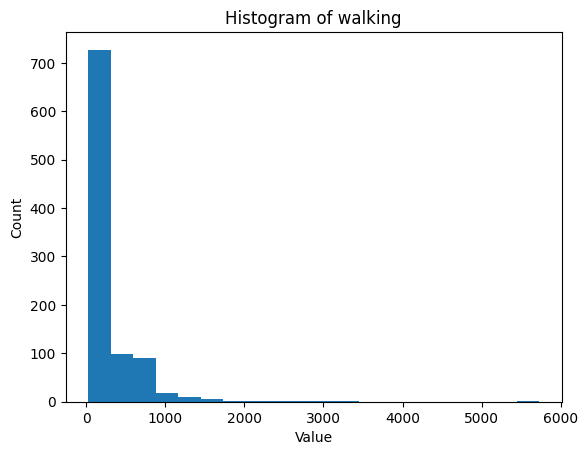

2
71 [1009, 1096, 1805, 2085, 418, 613, 443, 584, 580, 542, 463, 411, 665, 1433, 902, 1252, 2020, 3531, 3421, 2362, 1034, 940, 1094, 1043, 704, 498, 1569, 751, 559, 1014, 676, 1022, 1000, 360, 396, 414, 452, 395, 440, 790, 480, 1201, 1803, 1049, 1743, 987, 811, 875, 829, 1088, 784, 794, 1006, 720, 1009, 881, 473, 646, 525, 484, 466, 473, 398, 466, 475, 489, 432, 880, 940, 986, 938]


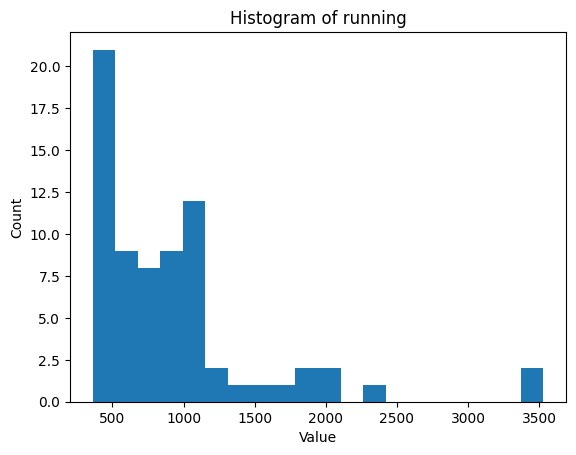

3
436 [304, 257, 254, 262, 236, 249, 256, 293, 317, 237, 224, 246, 222, 237, 340, 269, 255, 251, 261, 255, 292, 289, 268, 304, 317, 242, 280, 247, 247, 226, 226, 237, 251, 900, 299, 349, 339, 363, 357, 385, 411, 366, 414, 417, 498, 480, 439, 459, 330, 324, 245, 244, 345, 248, 231, 263, 233, 251, 241, 233, 163, 242, 252, 246, 244, 274, 273, 287, 266, 266, 270, 208, 208, 222, 329, 223, 296, 197, 205, 261, 297, 220, 307, 312, 196, 216, 201, 307, 290, 182, 181, 188, 301, 230, 295, 198, 286, 195, 188, 197]


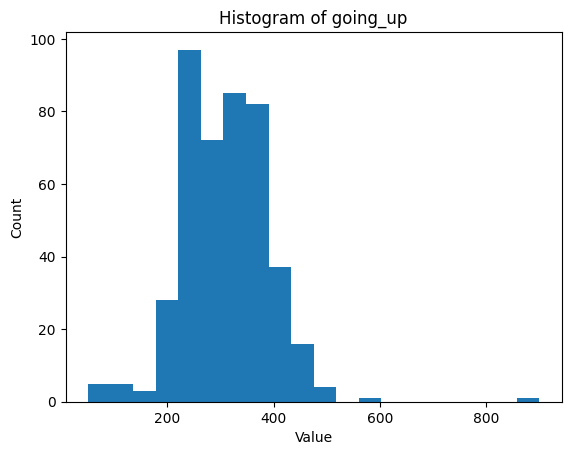

4
468 [240, 227, 195, 196, 194, 231, 264, 190, 204, 206, 211, 209, 267, 206, 203, 194, 184, 207, 207, 282, 243, 193, 186, 194, 219, 201, 199, 217, 193, 213, 240, 186, 201, 198, 211, 189, 211, 207, 179, 197, 199, 249, 344, 336, 307, 305, 467, 273, 277, 270, 287, 290, 396, 282, 316, 357, 197, 175, 199, 248, 231, 244, 247, 269, 219, 248, 243, 296, 370, 302, 351, 189, 177, 180, 112, 186, 182, 160, 165, 202, 315, 185, 179, 188, 182, 176, 177, 292, 307, 265, 278, 226, 267, 262, 280, 241, 178, 182, 276, 161]


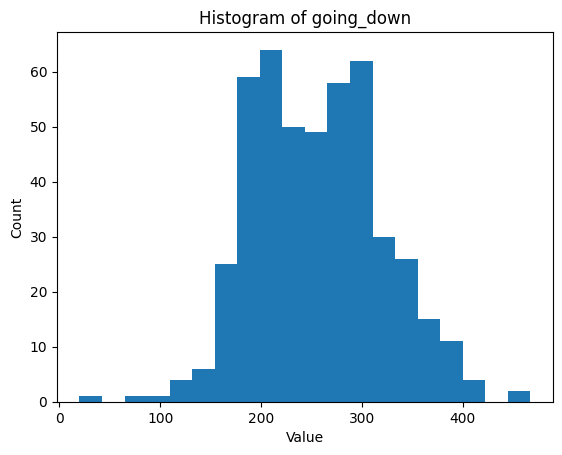

5
334 [167, 213, 385, 274, 411, 175, 239, 215, 60, 205, 217, 245, 318, 167, 192, 247, 251, 263, 113, 628, 302, 263, 209, 115, 125, 145, 223, 111, 194, 226, 193, 182, 213, 97, 134, 158, 191, 169, 159, 144, 165, 154, 190, 116, 114, 108, 508, 109, 147, 728, 217, 217, 159, 310, 237, 268, 222, 190, 249, 231, 202, 200, 99, 216, 195, 167, 221, 168, 136, 145, 169, 190, 93, 214, 190, 225, 832, 73, 236, 188, 174, 266, 168, 178, 145, 72, 202, 235, 186, 219, 86, 179, 167, 155, 173, 124, 535, 259, 228, 221]


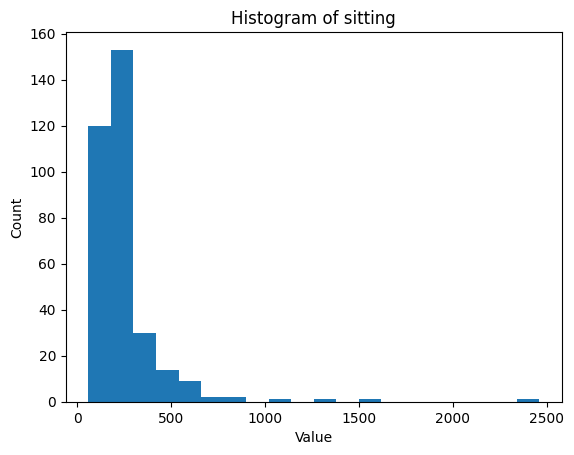

6
268 [126, 91, 97, 117, 87, 83, 92, 108, 106, 93, 79, 84, 103, 95, 76, 73, 91, 65, 100, 92, 76, 79, 67, 71, 87, 60, 55, 62, 59, 63, 60, 57, 57, 132, 118, 49, 55, 46, 88, 78, 97, 91, 100, 58, 52, 52, 47, 46, 58, 47, 53, 54, 56, 55, 62, 45, 52, 49, 48, 56, 51, 55, 64, 65, 67, 68, 65, 67, 58, 59, 57, 57, 64, 69, 55, 38, 47, 52, 61, 116, 84, 118, 109, 115, 128, 41, 47, 53, 52, 48, 70, 70, 79, 69, 64, 70, 69, 71, 76, 53]


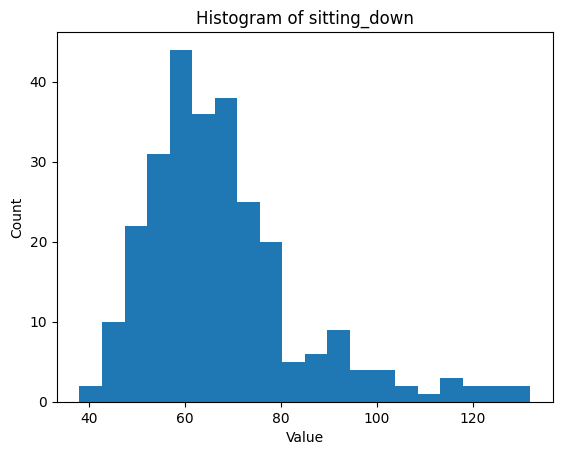

7
278 [125, 124, 110, 100, 96, 92, 82, 92, 94, 111, 96, 102, 87, 94, 92, 80, 147, 103, 86, 91, 79, 85, 84, 92, 75, 81, 87, 60, 63, 67, 73, 66, 78, 73, 81, 101, 70, 77, 71, 137, 67, 58, 58, 56, 71, 107, 68, 110, 159, 103, 92, 168, 77, 63, 76, 68, 60, 60, 69, 63, 66, 63, 65, 65, 66, 65, 61, 65, 69, 64, 68, 58, 73, 72, 74, 62, 71, 67, 65, 59, 69, 63, 74, 58, 53, 74, 60, 59, 83, 108, 118, 116, 115, 121, 64, 58, 55, 71, 60, 74]


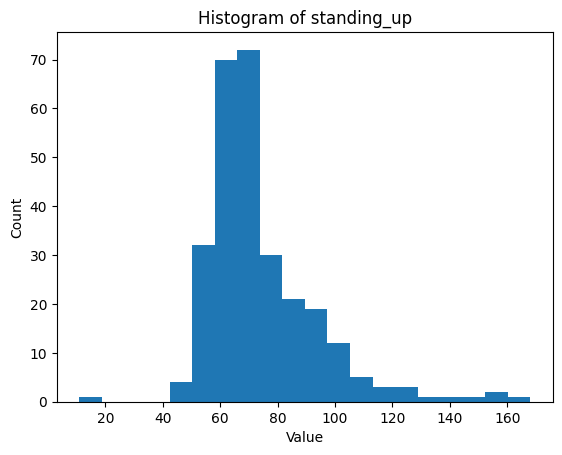

8
799 [248, 235, 347, 230, 267, 200, 149, 140, 156, 209, 316, 239, 170, 210, 242, 237, 175, 94, 144, 121, 182, 161, 186, 306, 159, 205, 121, 298, 268, 129, 236, 109, 284, 186, 273, 366, 316, 318, 173, 819, 125, 80, 112, 104, 75, 138, 150, 134, 232, 192, 112, 86, 97, 150, 78, 146, 75, 155, 81, 147, 162, 124, 134, 196, 150, 134, 120, 156, 101, 542, 95, 671, 73, 136, 127, 91, 225, 115, 99, 141, 73, 167, 75, 120, 106, 143, 78, 102, 117, 774, 131, 114, 89, 136, 170, 207, 226, 146, 278, 119]


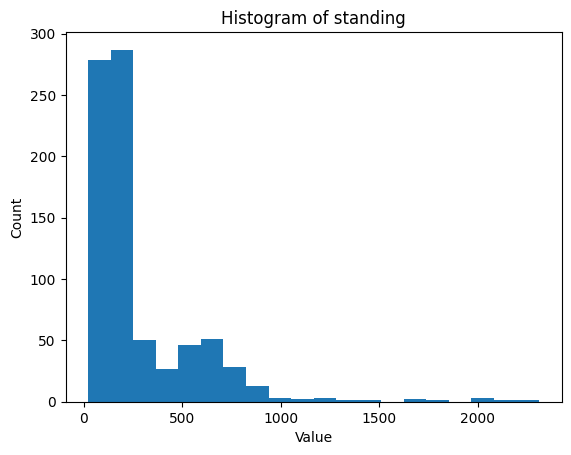

10
108 [1333, 1436, 1108, 1035, 530, 809, 959, 895, 884, 1001, 941, 466, 659, 529, 608, 386, 737, 551, 480, 962, 751, 840, 861, 519, 725, 428, 646, 737, 704, 979, 1098, 955, 458, 789, 646, 666, 842, 778, 575, 879, 825, 958, 1118, 1305, 928, 1072, 673, 362, 539, 621, 768, 532, 311, 221, 425, 547, 560, 586, 55, 445, 1222, 2523, 1789, 439, 511, 550, 736, 1553, 1782, 574, 1590, 670, 540, 1440, 1156, 885, 898, 477, 797, 397, 490, 474, 3405, 1292, 576, 1528, 1519, 548, 2139, 835, 1520, 395, 943, 653, 35, 87, 1213, 792, 760, 430]


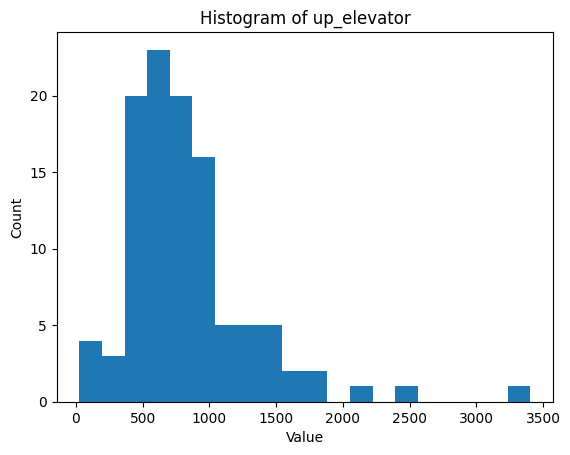

11
91 [1477, 1125, 930, 1127, 910, 850, 1017, 762, 1044, 1130, 1286, 636, 568, 718, 643, 498, 584, 893, 395, 731, 1491, 645, 661, 664, 652, 487, 296, 567, 756, 754, 554, 752, 636, 573, 695, 694, 755, 1019, 988, 1157, 970, 538, 756, 374, 663, 718, 1567, 849, 418, 448, 471, 755, 461, 544, 323, 1128, 342, 427, 550, 691, 426, 364, 446, 385, 983, 429, 955, 1491, 873, 613, 493, 888, 533, 605, 692, 468, 1677, 425, 530, 1055, 729, 448, 681, 778, 1244, 1301, 1434, 588, 128, 658, 1329]


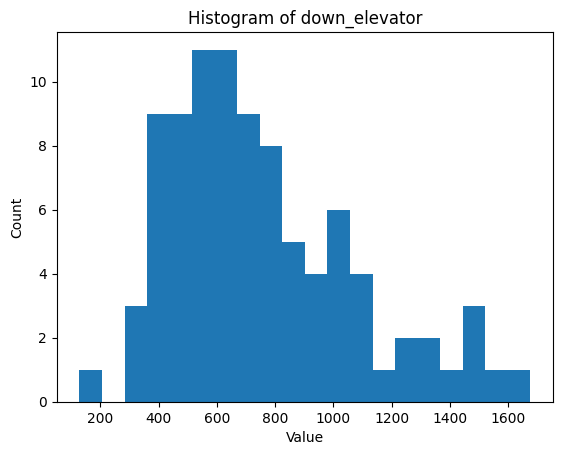

<Figure size 640x480 with 0 Axes>

In [46]:
# load labels and graph hist
def get_labels_start_end_time(frame_wise_labels, bg_class=[0]):
    labels = []
    starts = []
    ends = []
    last_label = frame_wise_labels[0]
    if frame_wise_labels[0] not in bg_class:
        labels.append(frame_wise_labels[0])
        starts.append(0)
    for i in range(len(frame_wise_labels)):
        if frame_wise_labels[i] != last_label:
            if frame_wise_labels[i] not in bg_class:
                labels.append(frame_wise_labels[i])
                starts.append(i)
            if last_label not in bg_class:
                ends.append(i)
                
            last_label = frame_wise_labels[i]
            
    if last_label not in bg_class:
        ends.append(i + 1)
        
    lens = [e-s for e,s in zip(ends, starts)]
    return (labels, lens)


all_labs = [int(i) for i in all_labs]
print(all_labs[:5])
labs, lens = get_labels_start_end_time(all_labs)
print(labs[:10], len(labs))
print(lens[:10], len(lens))
import numpy as np
import matplotlib.pyplot as plt
classes = ['background', 'walking', 'running', 'going_up', 'going_down', 'sitting',
                      'sitting_down', 'standing_up', 'standing', 'bicycling', 'up_elevator',
                      'down_elevator']
for l in np.unique(labs):
    print(l)
    x = [lens[i]  for i in range(len(labs)) if labs[i]==l]
    print(len(x), x[:100])
    # Create histogram
    plt.hist(x, bins=20)

    # Add labels
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Histogram of {classes[l]}")

    # Show plot
    plt.show()
    plt.figure()


In [9]:
import numpy as np
lab = 'act'

for s in meta:
    print('session: ', s)
    pre = 'HuGaDB_v2_various_' + s
    
    t1 = []
    for i in files:
        #print(i)
        if i.startswith(pre):
            t1.append(i)
    t1.sort()
    #print(t1)
    
#     data = pd.read_csv(os.path.join(path, t1[0]), delimiter = "\t", header=0, skiprows=3)
#     print(data[lab].value_counts().sort_index())
#     print('sum: ', data[lab].value_counts().sum())
    
    for i in range(len(t1)):
        print('sub sess: ', t1[i])
#         data_temp = pd.read_csv(os.path.join(path, t1[i]), delimiter = "\t", header=0, skiprows=3)
        data = pd.read_csv(os.path.join(path, t1[i]), delimiter = "\t", header=0, skiprows=3)

#         if set(np.unique(data[lab])) == set([5,6,7,8]):
#             print(data[lab].value_counts().sort_index())
#             print('sum: ', data[lab].value_counts().sum())

#         data = pd.concat([data, data_temp], axis=0)
    
        data = data.reset_index(drop=True)

        markers = data.loc[:, ~data.columns.isin([lab, 'EMG_r', 'EMG_l'])]

        markers_np = markers.to_numpy()
        #print(markers_np)
        labels = list(data[lab])
        print(data[lab].value_counts())


#         lab_np = np.zeros((len(labels), 12))
#         for ind, l in enumerate(labels):
#             if l == 11:
#                 l = 9
#             lab_np[ind, l] = 1

#         lab_df = pd.DataFrame(lab_np, dtype=int)
#         display(lab_df)

        # save markers   
#         markers_path = path + '/markers/'  + t1[i][:-4] + '_labeled.npy'
#         markers_np = markers_np.astype('float64')
#         np.save(markers_path, markers_np)


#         # save labels
#         lab_path = path + '/labels-hand/' + t1[i][:-4] + '_labels.csv'
#         lab_df.columns = ['background', 'walking', 'running', 'going_up', 'going_down', 'sitting',
#                          'sitting_down', 'standing_up', 'standing', 'down_elevator', 'up_elevator']
#         lab_df.to_csv(lab_path)


session:  01
sub sess:  HuGaDB_v2_various_01_00.txt
5    1192
8    1060
7     459
6     431
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_01.txt
5    947
8    756
6    370
7    362
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_02.txt
5    1152
8     920
7     403
6     362
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_03.txt
5    1066
8     859
7     353
6     347
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_04.txt
1    2875
4    1283
8     269
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_05.txt
1    3131
3    2111
8     265
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_06.txt
1    3016
4    1284
8     343
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_07.txt
1    3144
3    1483
8     492
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_08.txt
3    2784
1    1734
8     364
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_01_09.txt
4    1750
1    1377
8     419
Name: act, dtype: int64
sub sess:  HuGaDB_v2_

1    3686
3    2011
8     115
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_06.txt
1    3630
4    1722
8     125
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_07.txt
1    3834
3    2013
8      91
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_08.txt
1    3803
4    1606
8     163
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_09.txt
4    288
8    252
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_10.txt
4    288
8    139
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_11.txt
4    291
8    183
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_12.txt
4    302
8    150
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_13.txt
3    343
8    226
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_14.txt
3    344
8    279
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_15.txt
3    321
8    249
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_06_16.txt
3    335
8    229
Name: act, dtype: int64
sub sess:  HuGaDB_v

10    1500
8     1497
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_04.txt
8     2687
11    1328
10     736
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_05.txt
4    1887
1    1160
8     195
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_06.txt
3    2306
1    1082
8     370
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_07.txt
4    2161
1    1123
8     394
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_08.txt
3    2328
1    1169
8     326
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_09.txt
3    1528
1     647
8     570
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_10.txt
4    1219
1     607
8     369
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_11.txt
4    2052
1    1496
8     772
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_12.txt
3    2416
1    1311
8     383
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_10_13.txt
5    969
8    550
6    233
7    199
Name: act, dtype: int64
sub sess:  HuGa

4    1455
1     743
8     274
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_14_14.txt
4    1516
1     735
8     328
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_14_15.txt
3    1824
1     745
8     336
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_14_16.txt
4    1624
1     843
8     262
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_14_17.txt
3    1888
1     826
8     274
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_14_18.txt
5    1168
8     632
7     237
6     231
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_14_19.txt
5    1057
8     522
6     243
7     235
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_14_20.txt
5    1045
8     577
7     226
6     225
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_14_21.txt
5    1501
8     613
6     221
7     202
Name: act, dtype: int64
session:  15
sub sess:  HuGaDB_v2_various_15_00.txt
4    1963
1     904
8     559
Name: act, dtype: int64
sub sess:  HuGaDB_v2_various_15_01.txt
3    2074
1    10

In [ ]:
# split up video
up_ele = 10
down_ele = 11 
standing = 8

train_vids = ['05', '07', '09', '12', '14']
test_vids = ['06', '08', '11', '13', '17']


# TRAIN_LABELED_5 = [5, 6, 8, 13, 14]

# TRAIN_UNLABELED_5 = [1, 2, 3, 10, 18]

# TEST_8 = [4, 7, 9, 11, 12, 15, 16, 17]

In [84]:
print('done')

done


# Save subsets

In [96]:
# get list of all text files
import glob
import os
import pandas as pd

os.chdir(path)
files = glob.glob('*.txt')
#rint((files))

nums = list(range(1, 19))
meta = [str(i)  if i > 9 else '0'+str(i) for i in nums]
print(meta)

files.sort()
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']
['HuGaDB_v2_various_01_00.txt', 'HuGaDB_v2_various_01_01.txt', 'HuGaDB_v2_various_01_02.txt', 'HuGaDB_v2_various_01_03.txt', 'HuGaDB_v2_various_01_04.txt', 'HuGaDB_v2_various_01_05.txt', 'HuGaDB_v2_various_01_06.txt', 'HuGaDB_v2_various_01_07.txt', 'HuGaDB_v2_various_01_08.txt', 'HuGaDB_v2_various_01_09.txt', 'HuGaDB_v2_various_01_10.txt', 'HuGaDB_v2_various_01_11.txt', 'HuGaDB_v2_various_01_12.txt', 'HuGaDB_v2_various_01_13.txt', 'HuGaDB_v2_various_01_14.txt', 'HuGaDB_v2_various_01_15.txt', 'HuGaDB_v2_various_01_16.txt', 'HuGaDB_v2_various_02_00.txt', 'HuGaDB_v2_various_02_01.txt', 'HuGaDB_v2_various_02_02.txt', 'HuGaDB_v2_various_02_03.txt', 'HuGaDB_v2_various_02_04.txt', 'HuGaDB_v2_various_02_05.txt', 'HuGaDB_v2_various_02_06.txt', 'HuGaDB_v2_various_03_00.txt', 'HuGaDB_v2_various_03_01.txt', 'HuGaDB_v2_various_03_02.txt', 'HuGaDB_v2_various_03_03.txt', 'HuGaDB_v2_various_03_

In [8]:
# new_files = [
#     'HuGaDB_v2_various_01_01.txt',
#     'HuGaDB_v2_various_04_01.txt', 
#     'HuGaDB_v2_various_04_02.txt',
#     'HuGaDB_v2_various_06_01.txt', 
#     'HuGaDB_v2_various_06_02.txt',
#     'HuGaDB_v2_various_07_01.txt', 
    
#     'HuGaDB_v2_various_08_01.txt',
#     'HuGaDB_v2_various_09_01.txt', 
#     'HuGaDB_v2_various_17_01.txt',
    
#     'HuGaDB_v2_various_08_02.txt', 
#     'HuGaDB_v2_various_01_02.txt',

# ]

In [107]:
import numpy as np
lab = 'act'

for s in new_files:
    print('session: ', s)
    
    
    data = pd.read_csv(os.path.join(path, s), delimiter = "\t", header=0, skiprows=3)
#     print(data[lab].value_counts().sort_index())
#     print('sum: ', data[lab].value_counts().sum())

    markers = data.loc[:, ~data.columns.isin([lab, 'EMG_r', 'EMG_l'])]
    
    markers_np = markers.to_numpy()
    labels = list(data[lab])
    
    
    
    lab_np = np.zeros((len(labels), 5))
    for ind, l in enumerate(labels):
        l = l-4
        lab_np[ind, l] = 1
    
    lab_df = pd.DataFrame(lab_np, dtype=int)
    #display(lab_df)
    
    # save markers   
    markers_path = path + '/markers/'  + s[:-4] + '_labeled.npy'
    print(markers_path)
    markers_np = markers_np.astype('float64')
    np.save(markers_path, markers_np)
    
    
    # save labels
    lab_path = path + '/labels-hand/' +  s[:-4] + '_labels.csv'
    lab_df.columns = ['background',  'sitting', 'sitting_down', 'standing_up', 'standing']
    lab_df.to_csv(lab_path)
    

session:  HuGaDB_v2_various_01_01.txt
/home/bsb2144/daart_utils/data/huga/markers/HuGaDB_v2_various_01_01_labeled.npy
session:  HuGaDB_v2_various_04_01.txt
/home/bsb2144/daart_utils/data/huga/markers/HuGaDB_v2_various_04_01_labeled.npy
session:  HuGaDB_v2_various_04_02.txt
/home/bsb2144/daart_utils/data/huga/markers/HuGaDB_v2_various_04_02_labeled.npy
session:  HuGaDB_v2_various_06_01.txt
/home/bsb2144/daart_utils/data/huga/markers/HuGaDB_v2_various_06_01_labeled.npy
session:  HuGaDB_v2_various_06_02.txt
/home/bsb2144/daart_utils/data/huga/markers/HuGaDB_v2_various_06_02_labeled.npy
session:  HuGaDB_v2_various_07_01.txt
/home/bsb2144/daart_utils/data/huga/markers/HuGaDB_v2_various_07_01_labeled.npy
session:  HuGaDB_v2_various_08_01.txt
/home/bsb2144/daart_utils/data/huga/markers/HuGaDB_v2_various_08_01_labeled.npy
session:  HuGaDB_v2_various_09_01.txt
/home/bsb2144/daart_utils/data/huga/markers/HuGaDB_v2_various_09_01_labeled.npy
session:  HuGaDB_v2_various_17_01.txt
/home/bsb2144/daar

In [105]:
print('done')

done
